<a href="https://colab.research.google.com/github/kabume/Bast/blob/main/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installing SuPyMode and depedencies

In [2]:
!python -m pip install SuPyMode --no-cache-dir --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.3/46.3 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 313.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 kB 203.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 252.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.6/74.6 kB 317.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 340.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.3/112.3 MB 215.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.7/86.7 kB 280.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 305.5/305.5 kB 254.1 MB/s eta 0:00:00


## Quick fix: restart the session after the !pip command above.
Go on Runtime/Restart Session

## Importing the package

In [13]:
from SuPyMode.workflow import Workflow, fiber_loader, Boundaries, BoundaryValue, DomainAlignment

wavelength = 1550e-9

fiber = fiber_loader.load_fiber('SMF28', clad_refractive_index=1.4444, remove_cladding=False)

boundaries = [
   Boundaries(right=BoundaryValue.SYMMETRIC, top=BoundaryValue.SYMMETRIC),
   Boundaries(right=BoundaryValue.SYMMETRIC, top=BoundaryValue.ANTI_SYMMETRIC)
]


workflow = Workflow(
   fiber_list=[fiber],             # List of fiber to be added in the mesh, the order matters.
   wavelength=wavelength,          # Wavelength used for the mode computation.
   resolution=80,                  # Number of point in the x and y axis [is divided by half if symmetric or anti-symmetric boundaries].
   x_bounds=DomainAlignment.LEFT,  # Mesh x-boundary structure.
   y_bounds=DomainAlignment.BOTTOM,# Mesh y-boundary structure.
   boundaries=boundaries,          # Set of symmetries to be evaluated, each symmetry add a round of simulation
   n_sorted_mode=3,                # Total computed and sorted mode.
   n_added_mode=2,                 # Additional computed mode that are not considered later except for field comparison [the higher the better but the slower].
   plot=True,             # Plot the geometry mesh before computation.
   auto_label=True,                # Auto labeling the mode. Label are not always correct and should be verified afterwards.
   itr_final=0.05,                 # Final value of inverse taper ratio to simulate
   index_scrambling=0              # Scrambling of refractive index value in order to lift mode degeneracy [useful for some analysis]
)

workflow.superset.plot(plot_type='field', itr_list=[1.0, 0.1])

workflow.superset.plot(plot_type='index')

workflow.superset.plot(plot_type='normalized-coupling')

workflow.superset.plot(plot_type='adiabatic')

ValidationError: 1 validation error for Workflow
plot_geometry
  Unexpected keyword argument [type=unexpected_keyword_argument, input_value=True, input_type=bool]
    For further information visit https://errors.pydantic.dev/2.11/v/unexpected_keyword_argument

In [11]:
from SuPyMode.workflow import Workflow, fiber_catalogue, configuration, Boundaries2D, AlphaProfile

clad_structure = configuration.ring.FusedProfile_02x02
fiber0 = fiber_catalogue.SMF28(wavelength=1.55e-6)
fiber1 = fiber_catalogue.SMF28(wavelength=1.55e-6)

workflow = Workflow(
    fiber_list=[fiber0,fiber1],
    clad_structure=clad_structure,
    fusion_degree=0.90,
    wavelength=1.55e-6,
    resolution=200,
    x_bounds="left-centering",
    y_bounds="top-centering",
    boundaries=[
        Boundaries2D(right="symmetric",bottom='symmetric'),
        Boundaries2D(right="anti-symmetric",bottom='symmetric')
    ],
    generate_report=False,
    debug_mode=True,
    n_sorted_mode=6
)

profile =AlphaProfile()

profile.add_taper_segment(
    alpha=0,
    initial_heating_length=5e-3,
    stretching_length=2e-3,
)

profile.initialize()

amplitudes, z, _ = superset.propagate(
    profile-profile,
    initial_amplitude=[1, 0, 0, 0, 0, 0],
    add_coupling = True,
    max_step = superset.wavelength / 400
)

ImportError: cannot import name 'fiber_catalogue' from 'SuPyMode.workflow' (/usr/local/lib/python3.12/dist-packages/SuPyMode/workflow.py)

In [4]:
import SuPyMode
print(SuPyMode.__version__)

2.1.5


In [5]:
from SuPyMode.workflow import Workflow, fiber_loader, Boundaries, BoundaryValue, DomainAlignment, Profile, StructureType

from PyOptik import MaterialBank

In [6]:
wavelength = 1550e-9

# %%
# Generating the fiber structure
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Here we define the cladding and fiber structure to model the problem
clad_structure = Profile()

clad_structure.add_structure(
    structure_type=StructureType.CIRCULAR,
    number_of_fibers=4,
    fusion_degree=0.4,
    fiber_radius=62.5e-6,
    # compute_fusing=True
)

clad_structure.refractive_index = MaterialBank.fused_silica.compute_refractive_index(wavelength)  # Refractive index of silica at the specified wavelength


fiber_list = [
    fiber_loader.load_fiber('DCF1300S_33', clad_refractive_index=clad_structure.refractive_index, position=clad_structure.cores[0]),
    fiber_loader.load_fiber('DCF1300S_26', clad_refractive_index=clad_structure.refractive_index, position=clad_structure.cores[1]),
    fiber_loader.load_fiber('DCF1300S_42', clad_refractive_index=clad_structure.refractive_index, position=clad_structure.cores[2]),
    fiber_loader.load_fiber('DCF1300S_33', clad_refractive_index=clad_structure.refractive_index, position=clad_structure.cores[3]),
]

In [9]:
boundaries = [
    Boundaries(right=BoundaryValue.SYMMETRIC, top=BoundaryValue.SYMMETRIC),
    Boundaries(right=BoundaryValue.SYMMETRIC, top=BoundaryValue.ANTI_SYMMETRIC),
]

workflow = Workflow(
    fiber_list=fiber_list,          # List of fiber to be added in the mesh, the order matters.
    clad_structure=clad_structure,  # Cladding structure, if None provided then no cladding is set.
    wavelength=wavelength,          # Wavelength used for the mode computation.
    resolution=80,                  # Number of point in the x and y axis [is divided by half if symmetric or anti-symmetric boundaries].
    x_bounds=DomainAlignment.LEFT,  # Mesh x-boundary structure.
    y_bounds=DomainAlignment.BOTTOM,# Mesh y-boundary structure.
    boundaries=boundaries,          # Set of symmetries to be evaluated, each symmetry add a round of simulation
    n_sorted_mode=3,                # Total computed and sorted mode.
    n_added_mode=5,                 # Additional computed mode that are not considered later except for field comparison [the higher the better but the slower].
    # plot_geometry=True,             # Plot the geometry mesh before computation.
    debug_mode=0,                   # Print the iteration step for the solver plus some other important steps.
    auto_label=True,                # Auto labeling the mode. Label are not always correct and should be verified afterwards.
    itr_final=0.1,                  # Final value of inverse taper ratio to simulate
    index_scrambling=1e-4           # Scrambling of refractive index value in order to lift mode degeneracy [useful for some analysis]
)

In [6]:
_ = workflow.superset.plot(plot_type='field', itr_list=[1.0, 0.1])

AttributeError: 'Workflow' object has no attribute 'solver'

In [10]:
_ = workflow.superset.plot(plot_type='beta')

AttributeError: 'Workflow' object has no attribute 'solver'

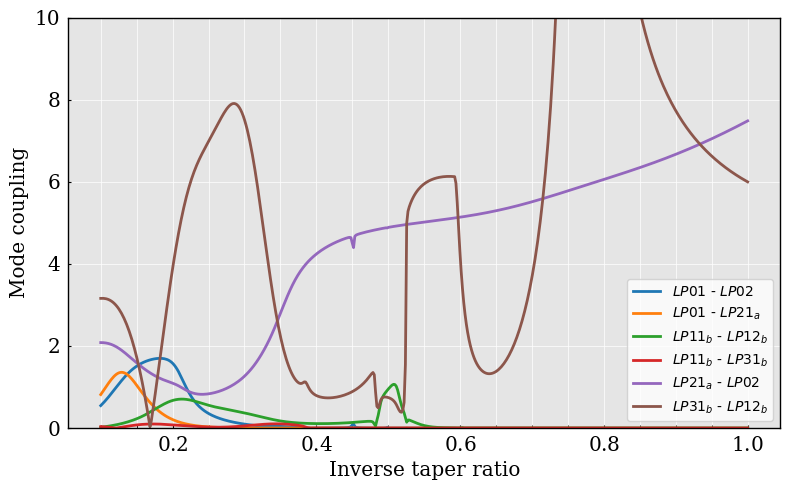

In [ ]:
_ = workflow.superset.plot(plot_type='normalized_coupling')

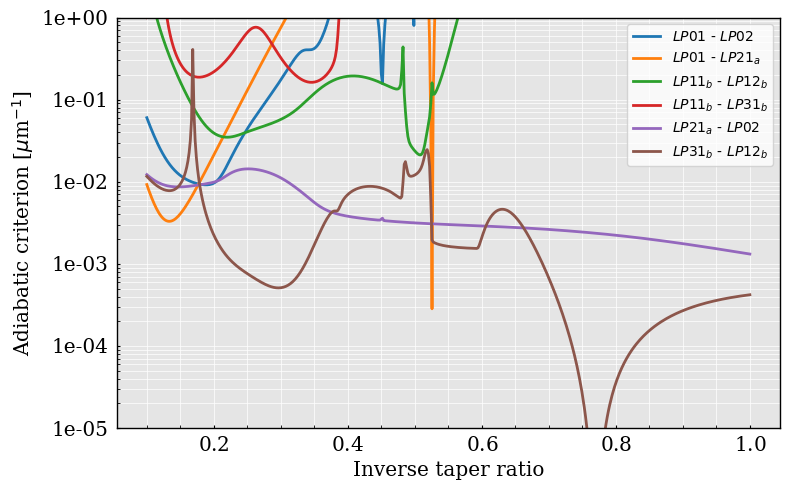

In [ ]:
_ = workflow.superset.plot(plot_type='adiabatic')